First Attempt

In [ ]:
# !pip install medmnist

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import os
import pandas as pd
import tensorflow as tf

from pathlib import Path
from medmnist import INFO, Evaluator
from tensorflow import keras
from tensorflow.keras import layers

print("MedMNIST version:", medmnist.__version__)
print("\n'pneumoniamnist' info dictionary:\n", INFO["pneumoniamnist"])

MedMNIST version: 3.0.2

'pneumoniamnist' info dictionary:
 {'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniam

In [36]:
BATCH_SIZE = 64

def load_npz_data(npz_path):
    """Load train, val, and test arrays from a given .npz file."""
    data = np.load(npz_path)
    
    # Adjust keys if necessary
    train_images = data['train_images']
    train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']
    test_images = data['test_images']
    test_labels = data['test_labels']
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

def create_tf_dataset_from_numpy(images, labels, batch_size=BATCH_SIZE):
    """Convert numpy arrays to a tf.data.Dataset, expanding grayscale images to 3 channels."""
    if images.ndim == 3:  # shape: (N, H, W)
        images = np.expand_dims(images, axis=-1)  # shape: (N, H, W, 1)
    if images.shape[-1] == 1:
        images = np.tile(images, (1, 1, 1, 3))   # convert grayscale to RGB
    
    images = images.astype(np.float32) / 255.0
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.batch(batch_size)
    return ds

In [33]:
for task in task_names:
    print(f"{task} => Train: {len(train_datasets[task])}, "
          f"Val: {len(val_datasets[task])}, "
          f"Test: {len(test_datasets[task])}")

pathmnist => Train: 89996, Val: 10004, Test: 7180
dermamnist => Train: 7007, Val: 1003, Test: 2005
octmnist => Train: 97477, Val: 10832, Test: 1000
pneumoniamnist => Train: 4708, Val: 524, Test: 624
retinamnist => Train: 1080, Val: 120, Test: 400
breastmnist => Train: 546, Val: 78, Test: 156
bloodmnist => Train: 11959, Val: 1712, Test: 3421
tissuemnist => Train: 165466, Val: 23640, Test: 47280
organamnist => Train: 34561, Val: 6491, Test: 17778
organcmnist => Train: 12975, Val: 2392, Test: 8216
organsmnist => Train: 13932, Val: 2452, Test: 8827


In [34]:
# Calculate and verify expected total test samples early
expected_total = sum(len(test_datasets[task]) for task in task_names)
print("Expected total test samples:", expected_total)

Expected total test samples: 96887


In [4]:
BATCH_SIZE = 64

def create_tf_dataset(medmnist_dataset, batch_size=BATCH_SIZE):
    """
    Convert medmnist dataset into a tf.data.Dataset that yields (images, labels).
    """
    x = medmnist_dataset.imgs  # shape: (N, 28, 28) if grayscale; or (N, 28, 28, 3) if as_rgb=True
    y = medmnist_dataset.labels.squeeze()  # shape: (N,) or (N,1)

    # Convert grayscale data to 3 channels if needed
    if len(x.shape) == 3:  # (N, 28, 28)
        x = np.expand_dims(x, axis=-1)  # (N, 28, 28, 1)
        # Optionally tile to 3 channels
        x = np.tile(x, (1, 1, 1, 3))  # (N, 28, 28, 3)

    # Create tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(buffer_size=len(x)).batch(batch_size)
    return ds

train_datasets_tf = {task: create_tf_dataset(train_datasets[task], BATCH_SIZE) for task in task_names}
val_datasets_tf   = {task: create_tf_dataset(val_datasets[task],   BATCH_SIZE) for task in task_names}
test_datasets_tf  = {task: create_tf_dataset(test_datasets[task],  BATCH_SIZE) for task in task_names}

In [5]:
class MultiTaskKerasModel(keras.Model):
    def __init__(self, task_names, data_flag_to_info):
        super().__init__()
        self.task_names = task_names
        
        # Simple CNN backbone
        self.conv1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D()
        self.flatten = layers.Flatten()
        
        # Classification heads: a Dense layer for each task
        self.heads = {}
        for task in task_names:
            n_classes = len(data_flag_to_info[task]['label'])
            self.heads[task] = layers.Dense(n_classes, name=f'head_{task}')

        self.heads = dict(self.heads)  # convert to normal dict for convenience

    def call(self, x, task=None, training=False):
        """
        Forward pass. If 'task' is provided, return that task's logits. 
        Otherwise return a dict of all tasks' logits.
        """
        # Shared feature extraction
        x = self.conv1(x, training=training)
        x = self.pool1(x)
        x = self.conv2(x, training=training)
        x = self.pool2(x)
        x = self.flatten(x)
        
        if task is not None:
            # Return only the relevant head
            return self.heads[task](x)
        else:
            # Return a dictionary of all heads (not strictly needed for round-robin)
            outputs = {}
            for t in self.task_names:
                outputs[t] = self.heads[t](x)
            return outputs

In [6]:
model = MultiTaskKerasModel(task_names, data_flag_to_info)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# We'll use SparseCategoricalCrossentropy for single-label classification
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

EPOCHS = 3  # small demo

In [8]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}...")
    epoch_loss = 0.0
    total_batches = 0
    
    # Round-robin over tasks
    for task in task_names:
        dataset = train_datasets_tf[task]
        
        for step, (images, labels) in enumerate(dataset):
            images = tf.cast(images, tf.float32) / 255.0  # scale [0, 255] -> [0, 1]
            
            with tf.GradientTape() as tape:
                logits = model(images, task=task, training=True)
                loss_value = loss_fn(labels, logits)
            
            vars_to_train = [
                var for var in model.trainable_variables
                if ("conv" in var.name or "pool" in var.name or "flatten" in var.name or f"head_{task}" in var.name)
                ]
            
            grads = tape.gradient(loss_value, vars_to_train)
            optimizer.apply_gradients(zip(grads, vars_to_train))
            
            epoch_loss += loss_value.numpy()
            total_batches += 1
    
    avg_loss = epoch_loss / total_batches if total_batches > 0 else 0.0
    print(f"  Loss: {avg_loss:.4f}")

Epoch 1/3...
  Loss: 0.8439
Epoch 2/3...
  Loss: 0.7721
Epoch 3/3...
  Loss: 0.7333


In [24]:
print("\nValidation Results:")
for task in task_names:
    all_preds = []
    
    # Collect predictions for each batch in the validation set of the current task
    for images, labels in val_datasets_tf[task]:
        images = tf.cast(images, tf.float32) / 255.0
        logits = model(images, task=task, training=False)
        preds = tf.argmax(logits, axis=1).numpy()
        all_preds.append(preds)

    # Concatenate predictions across all batches
    all_preds = np.concatenate(all_preds)

    # Determine number of classes for the current task using the length of the label mapping
    n_classes = len(data_flag_to_info[task]['label'])

    # Create a one-hot encoded matrix for predictions
    y_score = np.zeros((all_preds.shape[0], n_classes))
    y_score[np.arange(all_preds.shape[0]), all_preds] = 1

    # Initialize the Evaluator for the current task and validation split
    evaluator = Evaluator(task, split='val')

    # Evaluate using one-hot encoded predictions as scores
    metrics = evaluator.evaluate(y_score)

    # Extract accuracy and AUC from the returned Metrics object
    accuracy = metrics.ACC
    auc = metrics.AUC

    print(f"{task} => Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")


Validation Results:
pathmnist => Accuracy: 0.1236, AUC: 0.5005
dermamnist => Accuracy: 0.6630, AUC: 0.4989
octmnist => Accuracy: 0.4528, AUC: 0.5006
pneumoniamnist => Accuracy: 0.7347, AUC: 0.4949
retinamnist => Accuracy: 0.4500, AUC: 0.5115
breastmnist => Accuracy: 0.6154, AUC: 0.4962
bloodmnist => Accuracy: 0.1069, AUC: 0.4937
tissuemnist => Accuracy: 0.2131, AUC: 0.4998
organamnist => Accuracy: 0.1160, AUC: 0.5011
organcmnist => Accuracy: 0.1037, AUC: 0.4952
organsmnist => Accuracy: 0.0991, AUC: 0.4931



Macro F1 Scores per Task:
pathmnist: 0.1716
dermamnist: 0.1417
octmnist: 0.3364
pneumoniamnist: 0.4567
retinamnist: 0.2048
breastmnist: 0.7983
bloodmnist: 0.3146
tissuemnist: 0.2880
organamnist: 0.9463
organcmnist: 0.9544
organsmnist: 0.8181

Harmonic Mean of Macro F1 Scores: 0.3220


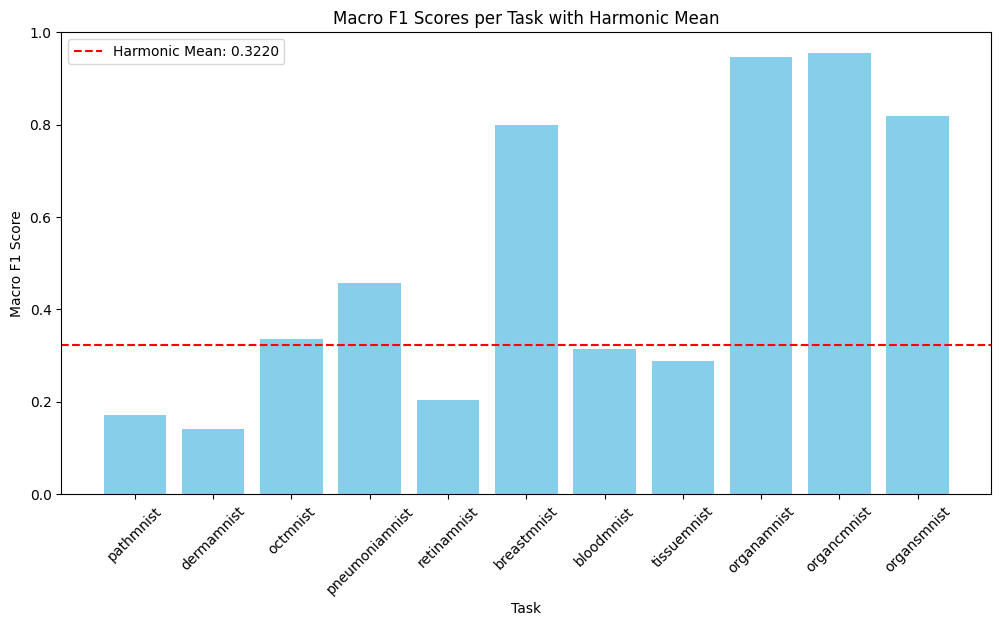

In [26]:
# Dictionary to store macro F1 scores for each task
macro_f1_scores = {}

print("\nMacro F1 Scores per Task:")
for task in task_names:
    all_preds = []
    all_labels = []

    # Collect predictions and true labels for the validation set of the current task
    for images, labels in val_datasets_tf[task]:
        images = tf.cast(images, tf.float32) / 255.0
        logits = model(images, task=task, training=False)
        preds = tf.argmax(logits, axis=1).numpy()
        
        all_preds.append(preds)
        all_labels.append(labels.numpy())

    # Concatenate predictions and labels across all batches
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute macro F1 score for current task
    f1 = f1_score(all_labels, all_preds, average='macro')
    macro_f1_scores[task] = f1
    print(f"{task}: {f1:.4f}")

# Compute harmonic mean of all macro F1 scores
f1_values = list(macro_f1_scores.values())
# Avoid division by zero
if all(f1 > 0 for f1 in f1_values):
    harmonic_mean = len(f1_values) / np.sum(1.0 / np.array(f1_values))
else:
    harmonic_mean = 0.0

print(f"\nHarmonic Mean of Macro F1 Scores: {harmonic_mean:.4f}")

# Plot the macro F1 scores for each task
tasks = list(macro_f1_scores.keys())
scores = list(macro_f1_scores.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(tasks, scores, color='skyblue')
plt.axhline(y=harmonic_mean, color='r', linestyle='--', label=f'Harmonic Mean: {harmonic_mean:.4f}')
plt.xlabel("Task")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Scores per Task with Harmonic Mean")
plt.xticks(rotation=45)
plt.legend()
plt.ylim([0, 1])
plt.show()

In [27]:
submission_rows = []
global_id = 0

for task in task_names:
    # We'll just iterate again in batch form
    # We'll keep a local index for each sample in this task
    idx_in_task = 0
    
    for images, _ in test_datasets_tf[task]:
        images = tf.cast(images, tf.float32) / 255.0
        logits = model(images, task=task, training=False)
        preds = tf.argmax(logits, axis=1).numpy()
        
        for pred_label in preds:
            submission_rows.append([
                global_id,
                idx_in_task,
                task,
                int(pred_label)
            ])
            global_id += 1
            idx_in_task += 1

# Convert to DataFrame
submission_df = pd.DataFrame(
    submission_rows,
    columns=["id", "id_image_in_task", "task_name", "label"]
)

print(submission_df.head(10))

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved to 'submission.csv'")

   id  id_image_in_task  task_name  label
0   0                 0  pathmnist      8
1   1                 1  pathmnist      5
2   2                 2  pathmnist      5
3   3                 3  pathmnist      1
4   4                 4  pathmnist      5
5   5                 5  pathmnist      5
6   6                 6  pathmnist      5
7   7                 7  pathmnist      5
8   8                 8  pathmnist      2
9   9                 9  pathmnist      5
Submission file saved to 'submission.csv'


In [28]:
submission_df

,id,id_image_in_task,task_name,label
0,0,0,pathmnist,8
1,1,1,pathmnist,5
2,2,2,pathmnist,5
3,3,3,pathmnist,1
4,4,4,pathmnist,5
...,...,...,...,...
96882,96882,8822,organsmnist,2
96883,96883,8823,organsmnist,4
96884,96884,8824,organsmnist,6
96885,96885,8825,organsmnist,6


In [29]:
expected_total = sum(len(test_datasets[task]) for task in task_names)
print("Expected total test samples:", expected_total)

Expected total test samples: 96887


In [30]:
for task in task_names:
    print(f"{task} test samples:", len(test_datasets[task]))
    

pathmnist test samples: 7180
dermamnist test samples: 2005
octmnist test samples: 1000
pneumoniamnist test samples: 624
retinamnist test samples: 400
breastmnist test samples: 156
bloodmnist test samples: 3421
tissuemnist test samples: 47280
organamnist test samples: 17778
organcmnist test samples: 8216
organsmnist test samples: 8827
